<h1><center> RNN-based Classification of arXiv Titles </h1></center>

### Get data from arXiv

From [Wikipedia](https://en.wikipedia.org/wiki/ArXiv): "arXiv (pronounced 'archive') is a repository of electronic preprints (known as e-prints) approved for publication after moderation, that consists of scientific papers in the fields of mathematics, physics, astronomy, computer science, quantitative biology, statistics, and quantitative finance, which can be accessed online."

The code below uses the package [arxivpy](https://github.com/titipata/arxivpy), which is a wrapper for the [arXiv API](https://arxiv.org/help/api/index).

We use it to fetch titles, categories, and published dates from paper submissions in the 'cs' (Computer Science) and 'stats' (Statistics) categories, in the following sub-categories:

- cs.CV: Computer Vision and Pattern Recognition
- cs.CL: Computation and Language
- cs.LG: Learning
- cs.AI: Artificial Intelligence
- cs.NE: Neural and Evolutionary Computing
- stat.ML: Machine Learning

#### Important:
There is no need to run the cell below, as the dataset is already provided in the 'data' folder. It takes a long time to run.

In [ ]:
# import arxivpy
# import pandas as pd

# category_list = ['cs.CV', 'cs.CL', 'cs.LG', 'cs.AI', 'cs.NE', 'stat.ML']

# titles = []
# terms1 = []
# terms2 = []
# dates = []

# for category in category_list:
#     search_query = arxivpy.generate_query(terms=category, prefix='category')
#     articles = arxivpy.query(search_query, start_index=0, max_index=5000, results_per_iteration=1000, wait_time=5.0, sort_by='lastUpdatedDate')
#     for i in range(len(articles)):
#         titles.append(articles[i]['title'])
#         terms1.append(articles[i]['term'])
#         terms2.append(articles[i]['terms'])
#         dates.append(articles[i]['publish_date'])

# dataset = pd.DataFrame({'title': titles, 'term':terms1, 'terms':terms2, 'publish_date':dates})
# dataset.to_csv('data/arxiv_dataset.csv', index=False)

### Upgrade CNTK to the latest version

The default CNTK version for the Python runtimes in Azure Notebooks is 2.0 (when this notebook was created). The CNTK model in this notebook was created and trained with CNTK 2.4. Therefore it is necessary to upgrade CNTK due to compatibility issues between CNTK versions. Here we upgrade it to the latest version.

In [1]:
!pip install --upgrade --no-deps cntk

    100% |████████████████████████████████| 72.7MB 15kB/s eta 0:00:011 6% |██▎                             | 5.0MB 2.5MB/s eta 0:00:28    11% |███▋                            | 8.2MB 3.7MB/s eta 0:00:18    12% |███▉                            | 8.7MB 2.7MB/s eta 0:00:25    12% |████                            | 9.1MB 2.6MB/s eta 0:00:25    31% |██████████                      | 22.8MB 2.3MB/s eta 0:00:22    34% |███████████                     | 24.8MB 2.6MB/s eta 0:00:19    34% |███████████▏                    | 25.3MB 2.1MB/s eta 0:00:23    48% |███████████████▍                | 34.9MB 2.8MB/s eta 0:00:14    50% |████████████████▏               | 36.7MB 5.2MB/s eta 0:00:07    52% |████████████████▊               | 38.0MB 5.4MB/s eta 0:00:07    53% |█████████████████▎              | 39.2MB 2.5MB/s eta 0:00:14    56% |██████████████████              | 40.8MB 3.3MB/s eta 0:00:10    61% |███████████████████▊            | 44.8MB 3.4MB/s eta 0:00:09    62% |████████████████████            

### Load required packages

In [2]:
import cntk as C
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
print(C.__version__)

2.5.1


### Load and prepare arXiv data

Here we load the provided dataset and build a list with all unique titles available that will be used for the model training.

For this classification task, we keep inly titles belonging to the 3 largest categories. We also preprocess the data by removing any title that has some character that is not an ASCII letter, not a digit, not a punctuation character, or not a blank space.

Finally we "clean" the text by removing tokens that we think will not contribute for the classification task. In our simple case, we just remove punctuation, digits, and trim whitespaces.

In [4]:
data = pd.read_csv('data/arxiv_categories.csv', engine='python')
data = data.drop_duplicates().reset_index()

print(data['terms'].value_counts())
terms = ['cs.CV', 'cs.AI', 'cs.CL']
data = data.loc[data['terms'].isin(terms)].reset_index()

titles = data['title']
categories = data['terms']
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
valid_titles = []
valid_categories = []
for i in range(len(titles)):
    invalids = [char for char in titles[i] if char not in allowed_chars]
    if len(invalids) == 0:
        valid_titles.append(titles[i])
        valid_categories.append(categories[i])
        
data = pd.DataFrame({'title': valid_titles, 'category': valid_categories})

def prepare_text(text):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    replace_numbers = str.maketrans(string.digits, ' '*len(string.digits))
    text = text.translate(replace_punctuation)
    text = text.translate(replace_numbers)
    text = re.sub(' +', ' ', text)
    text = text.lower()
    return text

data['title'] = data['title'].apply(lambda x: prepare_text(x))

print('\nSome examples of categories and titles in the data set:')
data.head()

cs.CV                                                                                                  9999
cs.AI                                                                                                  4031
cs.CL                                                                                                  3026
cs.LG                                                                                                  2377
cs.LG|stat.ML                                                                                          1865
stat.ML|cs.LG                                                                                          1676
stat.ML                                                                                                1483
cmp-lg|cs.CL                                                                                            890
cs.NE                                                                                                   857
cs.CV|cs.LG                 

,category,title
0,cs.CV,faces as lighting probes via unsupervised deep...
1,cs.CV,learning deep structured active contours end t...
2,cs.CV,activity detection with latent sub event hiera...
3,cs.CV,high resolution deep convolutional generative ...
4,cs.CV,improved part segmentation performance by opti...


### Create vocabulary and lookup dictionaries

Here we first create a list containing each unique word from all titles available in the dataset, and also a list containing each unique label in the dataset.

From these lists we then create 2 dictionaries:
One mapping from each word in the vocabulary to a numeric index, and the other mapping from each label to the corresponding numeric index.

These dictionaries will help to build the one-hot encoded representation of the data.

In [5]:
vocab_data = [title.split() for title in data['title']]
vocab_data = np.concatenate(vocab_data)
vocab = list(set(vocab_data))
vocab_len = len(vocab)
word_to_index = { w:i for i,w in enumerate(sorted(vocab)) }

labels = list(set(' '.join(data['category']).split()))
labels_len = len(labels)
label_to_index = { l:i for i,l in enumerate(sorted(labels)) }

avg_title_len = int(np.mean([len(x.split()) for x in data['title']]))
max_title_len = int(np.max([len(x.split()) for x in data['title']]))
min_title_len = int(np.min([len(x.split()) for x in data['title']]))

print('Average title length: %d' % avg_title_len)
print('Max title length: %d' % max_title_len)
print('Min title length: %d' % min_title_len)
print('Vocabulary Length: %d' % vocab_len)

Average title length: 9
Max title length: 32
Min title length: 2
Vocabulary Length: 11372


### Split the data into training, testing, and validation sets

Here we split the data into 90% for training, 5% for testing, and 5% for validation. The test data will be used to assess the progress of the model training, specially to see if the model is overfitting. The validation data will be used to assess the performance of the trained model.

In [6]:
np.random.seed(369)

data_train, data_test = train_test_split(data, train_size=0.9)
data_valid, data_test = train_test_split(data_test, train_size=0.5)

data_train = data_train.reset_index()
data_test = data_test.reset_index()
data_valid = data_valid.reset_index()

print('Number of instances in the training data: %d' % len(data_train))
print('Number of instances in the testing data: %d' % len(data_test))
print('Number of instances in the validation data: %d' % len(data_valid))

Number of instances in the training data: 15294
Number of instances in the testing data: 850
Number of instances in the validation data: 850


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Prepare batch data

CNTK has a high level API for efficient reading and feeding data for model training, which are very useful when you have data that doesn't fit into memory and it is then necessary to stream it from external storage into your training session. This API also takes care of efficient random sampling and batching, but has a proprietary data format. More details [here](https://cntk.ai/pythondocs/Manual_How_to_feed_data.html).

But in several situations, as this one, your data is already in a tabular format (such as a CSV file) and is small enough to be fitted in memory. In this case you have to explicitly prepare your training data, usually into mini-batches, as described here.

Now we prepare the data that will be fed into the neural network during model training. The function *create_mini_batches()* maps both the input text and labels to their corresponding numeric index. The mapping from this index to the corresponding one-hot encoded vector will be performed in the model definition.

We then use this function to generate 3 sets of data: one for model training, one for model testing, and one for model validation. All of these sets have 2 lists of mini-batches of 32 sequences each: one for the arXiv titles, which are the inputs for the model, and one with the corresponding true labels, which are the title categories. Notice that each input sequence will be unrolled for 'Backpropagation Through Time' during training, but the corresponding output is not a sequence. It corresponds to a single category instead.

In this way, we build inputs and outputs to be fed into the neural network allowing it to learn to classify a given arXiv title according to its category, as illustrated by the following diagram:

<img src="./figures/fig7.png" alt="RNN for predicting the next token" style="width: 600px;"/>

In CNTK we can just define each minibatch as a list of NumPy arrays. Notice that these NumPy arrays can be of variable sizes, corresponding to the variable lenghts we have for the arXiv titles.

As the labes are single values, it is more efficient to pack the corresponding entire lists into single NumPy arrays.

In [7]:
def create_mini_batches(data, mb_size):
    data_x = []
    data_y = []
    for seq in data['title']:
        index_x = [word_to_index[w] for w in seq.split()]
        index_x = np.array(index_x, dtype=np.float32)
        data_x.append(index_x)
    for label in data['category']:
        index_y = label_to_index[label]
        index_y = np.eye(labels_len, dtype=np.float32)[index_y]
        data_y.append(index_y)
    data_len = len(data_x)
    data_x = [data_x[s : s+mb_size] for s in range(0, data_len, mb_size)]
    data_y = [np.stack(data_y[s : s+mb_size]) for s in range(0, data_len, mb_size)]
    return data_x, data_y

mb_size = 32
data_train_x, data_train_y = create_mini_batches(data_train, mb_size)
data_test_x, data_test_y = create_mini_batches(data_test, mb_size)
data_valid_x, data_valid_y = create_mini_batches(data_valid, mb_size)

num_mb_train = len(data_train_x)
print('Number of minibatches for training: %d' % num_mb_train)

num_mb_test = len(data_test_x)
print('Number of minibatches for testing: %d' % num_mb_test)

print('Shapes of the first 5 elements in the first minibatch of data_train_x:')
for i in range(5):
    print(data_train_x[0][i].shape)

print('Shapes of the first 5 elements in the first minibatch of data_train_y:')
for i in range(5):
    print(data_train_y[0][i].shape)

Number of minibatches for training: 478
Number of minibatches for testing: 27
Shapes of the first 5 elements in the first minibatch of data_train_x:
(7,)
(11,)
(9,)
(13,)
(12,)
Shapes of the first 5 elements in the first minibatch of data_train_y:
(3,)
(3,)
(3,)
(3,)
(3,)


### Define input and output variables, and the netwotk model

The neural network we build has the architecture shown in the following diagram:

<img src="./figures/fig8.png" alt="RNN model architecture" style="width: 600px;"/>

It takes as input a vector of one-hot encoded words corresponding to a given arXiv title from the dataset. This one-hot encoded vectors go to an Embedding Layer, which maps the one-hot encoded vectors into a lower dimensional vector space (of size 64 in our model). The output of the Embedding Layer goes to the first Recurrent Neural Network block, which is comprised of a Stabilization Layer, a Normalization Layer, a GRU-based bi-directional Recurrent Layer, and a Dropout Layer. The output of this Recurrent Neural Network block is then fed into a second Recurrent Neural Network block similar to the first, but instead of a bi-directional Recurrent Layer it has a one-directional. The output of this second block goes into a simple [Attention](http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/) Layer. FInally, the output of the Attention Layer goes into a sequence of 2 blocks of a Dropout Layer folowwed by a Dense Layer.

Notice that the Recurrent Neural Network block is constructed in a way that we can define the stacking of multiple such blocks, using the CNTK *For()* function.

Notice also that it is a common pattern in CNTK (and also in other Deep Learning frameworks) to define the last Dense Layer without an activation function when performing multinomial classification. The activation (Softmax in this case) is defined later, together with the model Cost (Loss) Function.

The placeholder for the input values is defined by the variable *X*. The variable *Y* defines the placeholder for the oputput values, which are used to "teach the network" the true labels in a supervised manner during training. Remember that in our setup a true label is defined as the category of a given arXiv title.

The actual RNN model is defined by the *create_model()* function. CNTK's [Layer library](https://docs.microsoft.com/en-us/python/cognitive-toolkit/layerref?view=cntk-py-2.5.1) allows you to build models in a pattern known as [Function Composition](https://en.wikipedia.org/wiki/Function_composition).

In this way we instantiate our RNN model just by calling the *create_model()* function, passing the the one-hot encoded representation of the input to it. The return of this function is the model predicted output, defined by the variable *Z*.



In [8]:
X = C.sequence.input_variable(shape=(1))
X_onehot = C.reshape(C.one_hot(X, num_classes=vocab_len), shape=vocab_len)
Y = C.input_variable(shape=(labels_len))

n_embed = 64
n_hidden = 32
n_layers = 2
dropout = 0.4

def create_model(x):    
    with C.layers.default_options(initial_state=0):
        for i in range(n_layers):
            if i == 0:
                x = C.layers.Embedding(shape=n_embed)(x)
                x = C.layers.Stabilizer()(x)
                x = C.layers.LayerNormalization()(x)
                x1 = C.layers.Recurrence(C.layers.GRU(shape=n_hidden))(x)
                x2 = C.layers.Recurrence(C.layers.GRU(shape=n_hidden), go_backwards=True)(x)
                x = C.splice(x1, x2)
                x = C.layers.Dropout(dropout_rate=dropout)(x)
            else:
                x = C.layers.Stabilizer()(x)
                x = C.layers.LayerNormalization()(x)
                x = C.layers.Recurrence(C.layers.GRU(shape=n_hidden))(x)
                x = C.layers.Dropout(dropout_rate=dropout)(x)
        ################################ attention layer
        a = C.layers.Dense(shape=n_hidden, activation=C.relu)(x)
        a = C.layers.Dense(shape=1, activation=C.softmax)(a)
        z = C.layers.Fold(C.plus)(C.element_times(a, x))
        ################################
        z = C.layers.Dropout(dropout_rate=dropout)(z)
        z = C.layers.Dense(shape=n_hidden/2, activation=C.relu)(z)
        z = C.layers.Dropout(dropout_rate=dropout)(z)
        z = C.layers.Dense(shape=labels_len, activation=None)(z)
    return z

Z = create_model(X_onehot)

### Define the error, cost function, learner and trainer objects

Next we define the CNTK objects needed for model training:

The model error, which is expressed as a classification error. We model the prediction of the next token as a classification problem, so given an input token the next token in the sequence is predicted at the output as one of the possible tokens in the vocabulary.

The model [cost function](https://en.wikipedia.org/wiki/Loss_function) (also known as the loss function), which is defined as the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss with [softmax](https://en.wikipedia.org/wiki/Softmax_function) (standard for classification problems).

The [learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Background) for the optimization algorithm, which is defined in a scheduled manner. This allows the specification of a decreasing learning rate as the optimization progresses.

The [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum), which is used by some optimization algorithms. In this case, it is also defined in a scheduled manner allowing for the momentum decaying as the optimization progresses.

The gradient clipping threshold, used to help avoiding the exploding gradient problem with RNNs.

The learner, which defines the optimization algorithm to be used during training. Here we use the [adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimization algorithm.

The progress_printer, which is an optional helper object that allows you to print learning statistics during model training.

The trainer object, which wraps the model predicted output *Z*, the *cost* function, the model *error*, the *learner*, and optionally the *progress_printer*.

And finally the evaluator, which is usually used for model assessment during training.

In [9]:
error = C.classification_error(Z, Y)

cost = C.cross_entropy_with_softmax(Z, Y)

lr = C.learning_parameter_schedule([0.0005 * mb_size]*5 +
                                   [0.0001 * mb_size]*10 +
                                   [0.00005 * mb_size]*10 +
                                   [0.00001 * mb_size],
                                   minibatch_size=mb_size,
                                   epoch_size=num_mb_train*mb_size)

m = C.momentum_schedule(0.999, minibatch_size=mb_size)

gc = 5.0

learner = C.adam(parameters=Z.parameters, lr=lr, momentum=m,
                 gradient_clipping_threshold_per_sample=gc,
                 gradient_clipping_with_truncation=True)

progress_printer = C.logging.ProgressPrinter(freq=num_mb_train, tag='Training')

trainer = C.Trainer(Z, (cost, error), learner, progress_printer)

evaluator = C.Evaluator(error)

print(C.logging.log_number_of_parameters(Z))

Training 757670 parameters in 27 parameter tensors.
None


### Train the model

CNTK also has a high level API for model training, which is described [here](https://cntk.ai/pythondocs/Manual_How_to_train_using_declarative_and_imperative_API.html). It allows you to define a training session object that takes care of the training loop and is very useful specially when training in a distributed fashion.

Another option, which we use here, is to explicitly control the training loop.

In this setup we define an outer loop that iterates over the entire training data. Each of these iterations is also known as an *epoch*. We also define an inner loop that iterates over the mini-batches. For each mini-batch, we feed the input and output values to the network in the *train_minibatch()* method of the *trainer* object. Finally we compute the loss for each mini-batch and for the entire epoch.

For this model we also compute the error for both the training and testing data at each epoch. The intuition for computing the error using a separate testing data is to assess the performance of the model training, specially to control for model overfitting.

#### Important:
There is no need to run the cell below, as a trained model is already provided in the 'models' folder. It takes a long time to run.

In [ ]:
# costs_train = []
# errors_train = []
# errors_test = []

# log = open('logs/classify_arxiv_word_log.txt' , 'a')

# iter = 10

# start_time = time.asctime()
# print('Start training time: ' + start_time)
# log.write('Start training time: ' + start_time + '\n\n')

# for i in range(iter):
    
#     print('Iteration: %i' % (i))
#     log.write('Iteration: %i' % (i) + '\n')
    
#     epoch_cost_train = 0
#     epoch_error_train = 0
#     epoch_error_test = 0
    
#     for k in range(num_mb_train):
#         mb_X, mb_Y = data_train_x[k], data_train_y[k]
#         arguments = ({X : mb_X, Y : mb_Y})
#         trainer.train_minibatch(arguments)
#         minibatch_cost = trainer.previous_minibatch_loss_average
#         minibatch_error = trainer.previous_minibatch_evaluation_average
#         epoch_cost_train += minibatch_cost / num_mb_train
#         epoch_error_train += minibatch_error / num_mb_train
    
#     print("Train cost after iteration %i: %f" % (i, epoch_cost_train))
#     log.write("Train cost after iteration %i: %f" % (i, epoch_cost_train) + '\n')
#     costs_train.append(epoch_cost_train)
    
#     print('Train error after iteration %i: %f' % (i, epoch_error_train))
#     log.write("Train error after iteration %i: %f" % (i, epoch_error_train) + '\n')
#     errors_train.append(epoch_error_train)
    
#     for k in range(num_mb_test):
#         mb_X, mb_Y = data_test_x[k], data_test_y[k]
#         arguments = ({X : mb_X, Y : mb_Y})
#         minibatch_error = evaluator.test_minibatch(arguments)
#         epoch_error_test += minibatch_error / num_mb_test
        
#     print("Test error after iteration %i: %f" % (i, epoch_error_test))
#     log.write("Test error after iteration %i: %f" % (i, epoch_error_test) + '\n')
#     errors_test.append(epoch_error_test)
    
# end_time = time.asctime()
# print('End training time: ' + end_time)
# log.write('End training time: ' + end_time + '\n')

# model_file = 'models/classify_arxiv_word_epoch_%d.dnn'  % (i+1)
# trainer.save_checkpoint(model_file)
    
# log.close()

# plt.figure()
# plt.plot(costs_train)

# plt.figure()
# plt.plot(errors_train)

# plt.figure()
# plt.plot(errors_test)

### Compute the output labels and correct predictions for training and validation datasets

Here we define the CNTK computations for the predictions, correct predictions, and the accuracy.

We loop through the list of mini-batches for both training and validation sets, keeping track of the model accuracy and also the output labels. Then we compute the global accuracy for both sets. The model outputs will be used later for computing the confusion matrices.

Before running the cell below you need to run all but the commented cells above.

In [10]:
trainer.restore_from_checkpoint('models/classify_arxiv_word_epoch_10.dnn')
Z = trainer.model

correct_prediction = C.equal(C.argmax(Z), C.argmax(Y))
accuracy = C.reduce_mean(correct_prediction)
prediction = C.argmax(Z)

corrects_train = []
Yhat_train = []
for k in range(len(data_train_x)):
    mb_X, mb_Y = data_train_x[k], data_train_y[k]
    corrects = accuracy.eval({X: mb_X, Y: mb_Y})
    yhat = prediction.eval({X : mb_X})
    corrects_train.append(corrects)
    Yhat_train.append(yhat)

corrects_train = np.concatenate(corrects_train, axis=0)
print ("Train Accuracy:", corrects_train[corrects_train==1].shape[0] / corrects_train.shape[0])

corrects_valid = []
Yhat_valid = []
for k in range(len(data_valid_x)):
    mb_X, mb_Y = data_valid_x[k], data_valid_y[k]
    corrects = accuracy.eval({X: mb_X, Y: mb_Y})
    yhat = prediction.eval({X : mb_X})
    corrects_valid.append(corrects)
    Yhat_valid.append(yhat)

corrects_valid = np.concatenate(corrects_valid, axis=0)  
print ("Validation Accuracy:", corrects_valid[corrects_valid==1,].shape[0] / corrects_valid.shape[0])

Train Accuracy: 0.9839806460049693
Validation Accuracy: 0.908235294117647


### Plot the Confusion Matrix for both training and validation datasets

Finally we plot the [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for both the training and validation datasets.

The code for plotting is provided by the [scikit-learn](http://scikit-learn.org/stable/) website.

Normalized confusion matrix
[[0.97 0.02 0.01]
 [0.02 0.97 0.01]
 [0.   0.   0.99]]
Normalized confusion matrix
[[0.84 0.06 0.1 ]
 [0.08 0.83 0.09]
 [0.03 0.01 0.96]]


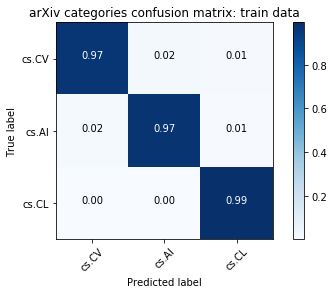

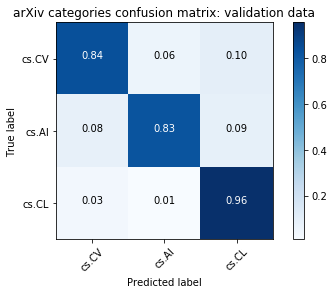

In [11]:
Yhat_train_1 = np.concatenate(Yhat_train, axis=0)
data_train_y_1 = np.concatenate(data_train_y, axis=0)

# convert from onehot back to index
data_train_y_1 = [np.where(i==1)[0][0] for i in data_train_y_1]

# compute confusion matrix
cm_train = confusion_matrix(data_train_y_1, Yhat_train_1)

Yhat_valid_1 = np.concatenate(Yhat_valid, axis=0)
data_valid_y_1 = np.concatenate(data_valid_y, axis=0)

# convert mb_Y from onehot back to index
data_valid_y_1 = [np.where(i==1)[0][0] for i in data_valid_y_1]

# compute confusion matrix
cm_valid = confusion_matrix(data_valid_y_1, Yhat_valid_1)

# plot confusion matrix
# code borrowed from scikit-learn.org
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm_train, classes = terms, title = 'arXiv categories confusion matrix: train data',
                      normalize=True)

plt.figure()
plot_confusion_matrix(cm_valid, classes = terms, title = 'arXiv categories confusion matrix: validation data',
                      normalize=True)